In [1]:
import os
# os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,floatX=float32'
os.environ['KERAS_BACKEND']='tensorflow'
os.sys.path.append('..')

In [2]:
# keras
import keras
# from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from keras.layers import InputLayer, Embedding, Lambda, Reshape, InputLayer, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.wrappers import Bidirectional, TimeDistributed

# from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from keras.layers import InputLayer, Embedding
from keras.models import Sequential

# helper
from keras_tqdm import TQDMNotebookCallback


Using TensorFlow backend.


In [3]:
# sklearn
import sklearn
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [4]:
# pylab imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
%matplotlib inline

# io & utils
from path import Path
from pprint import pprint
import json
import arrow
from tqdm import tqdm_notebook as tqdm

import re
import string
import itertools
import collections

In [5]:
seed=1337 # for reproducibility


In [6]:
import sklearn

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [7]:
import os
os.sys.path.append('.')

In [8]:
%reload_ext autoreload
%autoreload 2
from helpers import dataset_isledict, dataset_cmudict, show_results

# About

# What?

This project tried to build a spelling guesser, or technically a phoneme2grapheme translator.

# What, what?

Image you hear someone say a word for the first time:

- DYE-uh-REE-a

How is it spelt? We know the answer

- DYE-uh-REE-a => "Diarrhoea" 


But what if we didn't, here's a word you probobly don't know:

- PHA-NG-AH-RAY => 

[answer](https://en.wikipedia.org/wiki/Whangarei)

So we are building something that can take the pronounciation and guess the spelling.


# Data?

We want a dictionary of data like

pron | spelling 
--|--
DYE-uh-REE-a | Diarrhoea
PHA-NG-AH-RAY | -
 AR-kən-saw |  Arkansas
 
The best data comes from the CMU Pronouncing Dictionary with 140k entries

Pronounciation|Spelling
        -------| ------- |-----------
AA D|odd
AE T|at
HH AH T|hut
AO T|ought
K AW|cow
HH AY D|hide
B IY|be
CH IY Z|cheese
D IY|dee
DH IY|thee
EH D|Ed






 
# Why?

It can be used to 

- generate spelling for words that are not in the dictionary
- identify hard to spell words in english
- make a consistent spelling scheme for english?
- other things?
- no one's done it


# How

I'm not happy with my results, so what do you suggest?


# Metrics

The first steps is to decide on a metric and generate dummy benchmarks. That way we know what we have to beat.

Our metric is 

    Charector error rate: CER
    bad: 50% DYE-uh-REE-a =>	Dirrrhoaa
    good: 0% DYE-uh-REE-a =>	Diarrhoea

In [9]:
import numpy as np
def CER(y_pred,y_test):
    """
    A keras metric for Charecter error rate
    
    inputs:
        y_pred - an array with shape samples*index*classes
        y_test - as above    
    """
    return 1-(y_pred.argmax(-1)==y_test.argmax(-1)).sum()/(y_test.shape[0]*y_test.shape[1])
# print ('Char error rate {:%}'.format(CER(y_pred,y_test)))

from keras.utils.np_utils import to_categorical
# good
assert CER(
    np.array([to_categorical([0,2,1,4,0],5)]),
    np.array([to_categorical([0,2,1,4,0],5)])
) ==0

# bad
assert CER(
    np.array([to_categorical([0,2,1,4],5)]),
    np.array([to_categorical([0,2,0,2],5)])
)==0.5


# load data


My input data is the [CMUDict](http://www.speech.cs.cmu.edu/cgi-bin/cmudict) which maps english to the 39 ARPAbet phonemes. I then convert this to IPA.

I wrote helper functions to load the data
this is boring so I will leave it out - jeremy style

- download
- parse a text file
- remove duplicates
- turn charectors into numbers and back
    - a=>0, 0=>a, b=>2, ... etc
- turn phonemes into numbers and back
    - AH => 0, 0=>AH, ... etc
- split into 2 sets :( it should be three since we shouldn't use the test set for trying model archetectures


We will make it faster by restricting it to sequences of 10 or under
   

In [10]:
# grab a small subset of the data
(y_train, X_train),(y_test,X_test),(ytable,xtable) = dataset_isledict.get_data(
    verbose=1,
    max_phonemes=10,
    max_chars=10,
#     invert=False,
#     x_hot=True,
    unique_graphemes=True,
    unique_phonemes=True
    
)
X_train = X_train[:,::-1,:]
X_test = X_test[:,::-1,:]

nb_chars = len(ytable.chars)
nb_phons = len(xtable.chars)
maxlen_x = xtable.maxlen
maxlen_y = ytable.maxlen
batch_size = 300

loaded entries 282842
removed duplicate phonemes leaving 260707
removed duplicate graphemes leaving 236077
removed blacklisted entries leaving 158184
restricted to less than 10 phonemes leaving 113368 entries or 71.81%
X_train shape: (90879, 10, 29)
X_test shape: (22489, 10, 29)
y_train shape: (90879, 10, 43)
y_test shape: (22489, 10, 43)


In [11]:
# lets just do a sanity test
assert (X_train.sum(-1)==1).all(),'all classes must sum to one'
assert (y_train.sum(-1)==1).all(),'all classes must sum to one'
assert (X_train.max(-1)==1).all(),'should have max value of 1'
assert (X_train.min(-1)==0).all(), 'should have min of 0'

In [12]:
# view data
a=[''.join(x) for x in xtable.decode(X_train[:5])]
b=[''.join(y) for y in ytable.decode(y_train[:5])]
list(zip(a,b))

[(' ̩nmɚ˺diˈb', 'biederman '),
 ('    ̩nɹæˈm', 'marron    '),
 ('    ŋæˈɹps', 'sprang    '),
 ('  ieˌwlɔˈh', 'hallway   '),
 (' ɹɛˌʃtmɹɑˈ', 'armchair  ')]

# Dummy model

Our best dummy models get 60% CER or above

We have to a little massaging because scikit-learn works with 2d arrays while keras uses >2d. I use argmax, to_categorical, and reshape for this.

In [13]:
def to_categorical_3d(data2,n=None):
    data=data2.astype(np.int)
    return np.array([to_categorical(data[i],n) for i in range(len(data))])

In [14]:
from sklearn.dummy import DummyClassifier
for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    clf = DummyClassifier(strategy=strategy,random_state=0)
    clf.fit(X_train.reshape((-1,nb_phons)), y_train.reshape((-1,nb_chars)).argmax(-1))
    
    # on a simple classifier CER=1-score
    score = clf.score(X_test.reshape((-1,nb_phons)), y_test.reshape((-1,nb_chars)).argmax(-1))  
    print('{strategy:20.20s}: CER={CER:2.2%}'.format(strategy=strategy, CER=1-score))
    
#     # we get the same if we reshape from (329628,) to (27469, 12) 
#     # then make it categorical (27469, 12, 29)
#     y_pred = clf.predict(X_test.reshape((-1,nb_phons)))  
#     y_pred_2d = y_pred.reshape((-1,maxlen_y))
#     y_pred_3d = to_categorical_3d(y_pred_2d)
#     cer = CER(y_pred_3d, y_test)
#     print('CER={CER:2.2%}'.format(CER=cer))

stratified          : CER=87.83%
most_frequent       : CER=69.55%
prior               : CER=69.55%
uniform             : CER=96.58%


In [15]:
from sklearn.dummy import DummyRegressor
for strategy in ['mean', 'median', 'quantile', 'constant']:
    clf = DummyRegressor(strategy=strategy, constant=np.zeros((10,1)), quantile=0.555)
    clf.fit(X_train.argmax(-1), y_train.argmax(-1))
    score = clf.score(X_test.argmax(-1), y_test.argmax(-1))  
    y_pred_2d = clf.predict(X_test.argmax(-1))  
    y_pred_3d=to_categorical_3d(y_pred_2d)
    cer = CER(y_pred_3d, y_test)
    print('{strategy:20.20s}: CER={CER:2.2%}'.format(strategy=strategy, CER=cer))

mean                : CER=88.23%
median              : CER=71.10%
quantile            : CER=71.80%
constant            : CER=69.55%


# Helpers

- loss
    - dice_coef loss I recommend trying this for unbalanced classes (e.g. more e's), when kld and categorical cross-entropy don't work
- display
    - something to show our results as as table
    - progress logger to show predictons as we go
    - tqdm_keras to have fast progress bars


### Dice loss

Use it when you have unbalanced classes and the inbuild `kullback_leibler_divergence` wont work for you

$$ L     =  \frac{2*\sum{|A*B|}}{(\sum{A^2}+\sum{B^2})} $$

In [16]:
# define custom loss and metric functions 
from keras import backend as K
smooth = 1

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### PredictionLogger
With keras you can make custom callback so that you can see the prediction after every epoch. You will see it in action soon.

In [17]:
# PredictionLogger
import keras
from keras.callbacks import Callback
class PredictionLogger(keras.callbacks.Callback):
    def __init__(self, n=1):
        self.n = n

    def on_epoch_end(self, batch, logs={}):
        y_pred = self.model.predict(self.model.validation_data[0][:self.n])
        p_pred = ytable.decode(y_pred)
        p_test = ytable.decode(self.model.validation_data[1][:self.n])
        text_pred=[''.join(ls) for ls in p_pred]
        text_true=[''.join(ls) for ls in p_test]
        print('')
        pprint(list(zip(text_true,text_pred)))

prediction_logger = PredictionLogger(n=3)

# quick cnn

In [ ]:
from keras.layers import Embedding, Convolution1D, GlobalMaxPooling1D, Reshape, Flatten, Dropout
import keras
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(nb_phons,
                    90,
                    input_length=maxlen_x,
                    dropout=0.2))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=256,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(Dropout(0.2))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=256,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))

# model.add(Dropout(0.2))
# # # we add a Convolution1D, which will learn nb_filter
# # # word group filters of size filter_length:
# model.add(Convolution1D(nb_filter=256,
#                         filter_length=3,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))

# we use max pooling:
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
# model.add(Convolution1D(nb_filter=1,
#                         filter_length=1,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))

# classifier
model.add(Flatten())
model.add(Dense(maxlen_y*nb_chars))
model.add(Reshape((maxlen_y,nb_chars)))

model.add(Activation('softmax'))
model.compile(loss=dice_coef_loss,
              optimizer='nadam', #keras.optimizers.Nadam(lr=0.2),
              metrics=['accuracy'])
# model.summary()

history = model.fit(
    X_train.argmax(-1), 
    y_train, 
    batch_size=batch_size, 
    nb_epoch=20, 
    verbose=0, 
    validation_data=[X_test.argmax(-1),y_test],
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2),
        PredictionLogger(n=3),
        TQDMNotebookCallback()
    ]
)

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



[('caucasoid ', 'cocksaa   '),
 ('brassfield', 'brasseell '),
 ('flashbulb ', 'flashelll ')]



[('caucasoid ', 'cocksooe  '),
 ('brassfield', 'brasfeel  '),
 ('flashbulb ', 'flasblll  ')]



[('caucasoid ', 'cocksooe  '),
 ('brassfield', 'brassfill '),
 ('flashbulb ', 'flachbll  ')]



[('caucasoid ', 'cocksooe  '),
 ('brassfield', 'brassfeld '),
 ('flashbulb ', 'flashbll  ')]



[('caucasoid ', 'cocksooe  '),
 ('brassfield', 'brassfelld'),
 ('flashbulb ', 'flashbel  ')]


In [ ]:
pd.DataFrame(history.history).plot()

scores = model.evaluate(X_test.argmax(-1),y_test, verbose=0)
score = dict(zip(model.metrics_names,scores))

y_pred = model.predict(X_test.argmax(-1), verbose=0, batch_size=batch_size)

print ('Accuracy        {:%}'.format(score['acc']))
print ('Word error rate {:%}'.format(WER(y_pred,y_test)))
print ('Char error rate {:%}'.format(CER(y_pred,y_test)))
n=10
show_results(ytable=ytable, y_pred=y_pred[:n],y_test=y_test[:n],xtable=xtable,X_test=X_test[:n])

In [ ]:
## not dice loss

In [29]:
from keras.layers import Embedding, Convolution1D, GlobalMaxPooling1D, Reshape, Flatten, Dropout
import keras
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(nb_phons,
                    90,
                    input_length=maxlen_x,
                    dropout=0.2))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=256,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(Dropout(0.2))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=256,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))

# model.add(Dropout(0.2))
# # # we add a Convolution1D, which will learn nb_filter
# # # word group filters of size filter_length:
# model.add(Convolution1D(nb_filter=256,
#                         filter_length=3,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))

# we use max pooling:
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
# model.add(Convolution1D(nb_filter=1,
#                         filter_length=1,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))

# classifier
model.add(Flatten())
model.add(Dense(maxlen_y*nb_chars))
model.add(Reshape((maxlen_y,nb_chars)))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='nadam', #keras.optimizers.Nadam(lr=0.2),
              metrics=['accuracy'])
# model.summary()

history = model.fit(
    X_train.argmax(-1), 
    y_train, 
    batch_size=batch_size, 
    nb_epoch=20, 
    verbose=0, 
    validation_data=[X_test.argmax(-1),y_test],
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2),
        PredictionLogger(n=3),
        TQDMNotebookCallback()
    ]
)

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



[('caucasoid ', 'cocksoo   '),
 ('brassfield', 'brassfll  '),
 ('flashbulb ', 'flacbbrl  ')]



[('caucasoid ', 'coccsore  '),
 ('brassfield', 'brassflld '),
 ('flashbulb ', 'flasbbll  ')]



[('caucasoid ', 'coccsaae  '),
 ('brassfield', 'brasfflld '),
 ('flashbulb ', 'flachbal  ')]



[('caucasoid ', 'coccsoie  '),
 ('brassfield', 'brassflldd'),
 ('flashbulb ', 'flashblll ')]



[('caucasoid ', 'coccooie  '),
 ('brassfield', 'brasffeldd'),
 ('flashbulb ', 'flashble  ')]



[('caucasoid ', 'coccsoie  '),
 ('brassfield', 'brasffildd'),
 ('flashbulb ', 'flashblel ')]



[('caucasoid ', 'coccsoid  '),
 ('brassfield', 'brassfeld '),
 ('flashbulb ', 'flashbull ')]



[('caucasoid ', 'coccsoiee '),
 ('brassfield', 'brassfildd'),
 ('flashbulb ', 'flashbubl ')]



[('caucasoid ', 'coccsoid  '),
 ('brassfield', 'brassfeldd'),
 ('flashbulb ', 'flashblbl ')]



[('caucasoid ', 'coccooid  '),
 ('brassfield', 'brassfeldd'),
 ('flashbulb ', 'flashbubl ')]



[('caucasoid ', 'coccsoid  '),
 ('brassfield', 'brassfeldd'),
 ('flashbulb ', 'flashbubl ')]



[('caucasoid ', 'coccsoid  '),
 ('brassfield', 'brasffildd'),
 ('flashbulb ', 'flashbeb  ')]



[('caucasoid ', 'coccooid  '),
 ('brassfield', 'brassfildd'),
 ('flashbulb ', 'flashbubl ')]



[('caucasoid ', 'cocksoid  '),
 ('brassfield', 'brassfeldd'),
 ('flashbulb ', 'flashbubl ')]



[('caucasoid ', 'cocksoid  '),
 ('brassfield', 'brassieldd'),
 ('flashbulb ', 'flashbll  ')]



[('caucasoid ', 'cocksoid  '),
 ('brassfield', 'brassfeld '),
 ('flashbulb ', 'flashber  ')]



[('caucasoid ', 'coccsoid  '),
 ('brassfield', 'brassiildd'),
 ('flashbulb ', 'flashblll ')]



[('caucasoid ', 'coccooid  '),
 ('brassfield', 'brassfilld'),
 ('flashbulb ', 'flashblb  ')]



[('caucasoid ', 'coccsoid  '),
 ('brassfield', 'brassfildd'),
 ('flashbulb ', 'flashblb  ')]



[('caucasoid ', 'cocksoid  '),
 ('brassfield', 'brassfildd'),
 ('flashbulb ', 'flashblb  ')]


Accuracy        77.108367%
Word error rate 80.812842%
Char error rate 22.891636%


pronunciation,guess,spelling
kˈɑkəsˌɔid,cocksoid,caucasoid
bɹˈæsfˌild,brassfildd,brassfield
flˈæʃbl̩b,flashblb,flashbulb
hˈɛstiə,hestia,hestia
kɹˈæbi,crabyy,crabby
tɹədˈus,troduse,traduce
təlˈulə,talulaa,tallulah
bˈitn̩,beatn,beaton
hˈɑlɪtʃɛk,halicck,holecek
beidˈɔiə,bedooy,bedoya


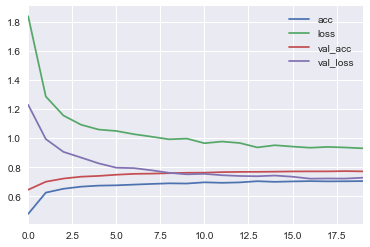

In [73]:
pd.DataFrame(history.history).plot()

scores = model.evaluate(X_test.argmax(-1),y_test, verbose=0)
score = dict(zip(model.metrics_names,scores))

y_pred = model.predict(X_test.argmax(-1), verbose=0, batch_size=batch_size)

print ('Accuracy        {:%}'.format(score['acc']))
print ('Word error rate {:%}'.format(WER(y_pred,y_test)))
print ('Char error rate {:%}'.format(CER(y_pred,y_test)))
n=10
show_results(ytable=ytable, y_pred=y_pred[:n],y_test=y_test[:n],xtable=xtable,X_test=X_test[:n])

# Using a sequence2sequence rnn with attention

This notebook uses the seq2seq translator with "attention" for alignment.

We choose this because this model has had great results (a 24% word error rate) for grapheme two phoneme translation. We are doing it the other way round: phoneme to grapheme. This is a bit harder but the same model should work well.

I tried lots of anttenion layer for keras but in the end I wrote by own by porting from tensorflow. This is based on [tensorflows implementation](https://github.com/tensorflow/tensorflow/blob/c8a45a8e236776bed1d14fd71f3b6755bd63cc58/tensorflow/python/ops/seq2seq.py#L506).



In [18]:
from helpers.layers import Attention, SimplifiedAttention

In [74]:
# set model parameters
nb_chars = len(ytable.chars)
nb_phons = len(xtable.chars)
maxlen_x = xtable.maxlen
maxlen_y = ytable.maxlen
batch_size = 300
hidden_nodes = 128
RNN=keras.layers.recurrent.GRU

In [77]:
import tensorflow
import keras

# you probobly need these exact versions
assert keras.__version__=='1.2.2'
assert tensorflow.__version__=='1.0.0'

In [79]:
model = Sequential()
# hidden_nodes = 512

# Encode, bidirectional keeps the accuracy up at the end of the word
model.add(Bidirectional(RNN(hidden_nodes, return_sequences=True), batch_input_shape=(batch_size, maxlen_x, nb_phons)))
# model.add(RNN(hidden_nodes, return_sequences=True, batch_input_shape=(batch_size, maxlen_x, nb_phons)))
model.add(Dropout(0.2))

# Decode with attention
model.add(Attention(RNN(hidden_nodes, return_sequences=True, consume_less='mem')))
model.add(Dropout(0.2))

# # I could add some more RNN models
# model.add(RNN(hidden_nodes, return_sequences=True, consume_less='mem'))



# classifier
model.add(TimeDistributed(Dense(nb_chars)))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.summary()

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    nb_epoch=60, 
                    verbose=0, 
                    validation_split=0.2,
                    callbacks=[
                            keras.callbacks.EarlyStopping(patience=2),
                            PredictionLogger(n=3),
                            TQDMNotebookCallback(),
                            keras.callbacks.EarlyStopping('loss',2)
                        ]
                   )

8700/|/[loss: 2.597, acc: 0.308]  12%|| 8700/72703 [06:29<46:19, 23.03it/s]

KeyboardInterrupt: 

9000/|/[loss: 2.586, acc: 0.310]  12%|| 9000/72703 [06:49<46:05, 23.03it/s]

In [ ]:
ts = arrow.utcnow().format('YYYYMM-DDHHmmss')
model_file = './models/{}_{}.hdf'.format('seq2seq_attention', ts)
model.save(model_file)
model_file

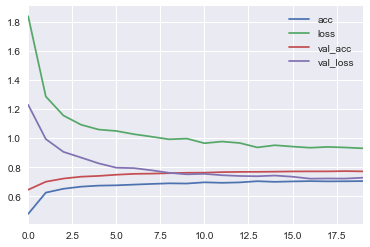

In [81]:
pd.DataFrame(history.history).plot()

In [ ]:
scores = model.evaluate(X_test,y_test, verbose=1, batch_size=batch_size)
score = dict(zip(model.metrics_names,scores))
print()
print ('Accuracy        {:%}'.format(score['acc']))

In [93]:
n=batch_size
y_pred = model.predict(X_test[:n], verbose=1, batch_size=batch_size)

print()
print ('Word error rate {:%}'.format(WER(y_pred[:n],y_test[:n])))
print ('Char error rate {:%}'.format(CER(y_pred[:n],y_test[:n])))

show_results(ytable=ytable, y_pred=y_pred[:n],y_test=y_test[:n],xtable=xtable,X_test=X_test[:n])

300/300 [==============================] - 5s
Word error rate 100.000000%
Char error rate 64.100000%


pronunciation,guess,spelling
kˈɑkəsˌɔid,oaaaeee,caucasoid
bɹˈæsfˌild,aaeeee,brassfield
flˈæʃbl̩b,aeeee,flashbulb
hˈɛstiə,eeeeee,hestia
kɹˈæbi,aeeee,crabby
tɹədˈus,oaeee,traduce
təlˈulə,aeeee,tallulah
bˈitn̩,aaeee,beaton
hˈɑlɪtʃɛk,oeeeee,holecek
beidˈɔiə,aeeee,bedoya


In [ ]:
# accuracy by class
r=(y_test-y_pred).reshape((-1,y_test.shape[-1]))
plt.plot(np.abs(r).mean(-1))

In [ ]:
# load best
# model.load_weights('./models/phone_to_respelling_201610-16142229.hdf')
# model = keras.models.load_model(model_checkpoint.filepath,custom_objects=dict(dice_coef_loss=dice_coef_loss))
model = keras.models.load_model('./models/phone_to_respelling_201610-19071704.hdf',custom_objects=dict(dice_coef_loss=dice_coef_loss))

In [ ]:
scores = model.evaluate(X_test,y_test, batch_size=batch_size, verbose=1)
score = dict(zip(model.metrics_names,scores))
score

In [ ]:
# model.save('./models/phone_to_respelling_201610-16142229_acc-{:2.2f}.hdf'.format(score['acc']))
# model.save_weights('./models/phone_to_respelling_201610-16142229_acc-{:2.2f}_weights.hdf'.format(score['acc']))

### visualise results

In [ ]:
n=10
y_pred = model.predict(X_test) 
show_results(ytable, y_pred[:n],y_test[:n])

In [ ]:
def word_error_rate(y_true,y_pred):
    # calc word error rate (compare 23.3-33.89 for grap2phon https://github.com/cmusphinx/g2p-seq2seq)
    # like https://github.com/cmusphinx/g2p-seq2seq/blob/master/g2p_seq2seq/g2p.py#L317
    c=(y_pred.argmax(-1)==y_true.argmax(-1)).all(-1).sum()
    return (1-c/len(y_true))

from leven import levenshtein 
def element_error_rate(y_true, y_pred, ytable=ytable):
    """Returns the word error rate of the supplied hypothesis with respect to
    the reference string."""
    c_test = [''.join(x).strip() for x in ytable.decode(y_true)]
    c_pred = [''.join(x).strip() for x in ytable.decode(y_pred)]
    distance = np.array([levenshtein(pred,test) for pred,test in zip(c_pred,c_test)])
    elems = np.array([len(x) for x in c_test])
    error_rate = distance / len(elems)
    return error_rate.sum()

wer = word_error_rate(y_test, y_pred)
print('word error rate {:2.2%}'.format(wer))

eer = element_error_rate(y_test, y_pred)
print('element (char or phon) error rate {:2.2%}'.format(eer))

In [ ]:
a=[[1,2,3],[1,2,3]]
b=[[1,2,3],[2,0,3]]
a=np.array([keras.utils.np_utils.to_categorical(x,4) for x in a])
b=np.array([keras.utils.np_utils.to_categorical(x,4) for x in b])
assert word_error_rate(a,b)==0.5
assert element_error_rate(a,b)==1

In [ ]:
# accuracy for each char
report = sklearn.metrics.classification_report(y_test.argmax(-1).flatten(), y_pred.argmax(-1).flatten(), target_names=ytable.chars)
print(report)

In [ ]:
# show confidence
conf = y_pred.max(-1)
plt.imshow(conf[:n],interpolation='none',vmin=0,vmax=1)
plt.colorbar()

In [ ]:
# TODO make this better, maybe just repeat the phoneme?
def show_possibilities(y_vis):
    """
    Given a y_prediction, dispay the most commonly predicted chars for each input
    
    e.g. 'AY2     ' gives 'AOU' for p>0.1
    """
    for k in range(len(xtable.chars)):

        # grab top choices
        choices = np.array([np.argsort(y_vis[k,j])[::-1] for j in range(y_vis.shape[1])])
        # and thier probs
        probs = np.array([[y_vis[k][i][choices[i][j]] for i in range(choices.shape[0])] for j in range(choices.shape[1])]).T

    #     print('most common chars (in order) p<0.1 for:')
        html='<h3>"{}" most likely chars (p>0.1)</h3>'.format(xtable.chars[k])
        res = ytable.decode(choices,calc_argmax=False)
        for i in range(res.shape[0]):
            html+='<div></div>'
            for j in range(res.shape[1]):
                c=res[i,j]
                a=np.sqrt(probs[i,j])
                if a>np.sqrt(0.1):
                    html+='<span style="color:rgba(0,0,0,{a:1.1f})">{c:}</span>'.format(c=c,a=a)
    #     pprint([''.join(y) for y in ytable.decode(choices,calc_argmax=False)])
        display(HTML(html))


# lets see what each phonemes predicts
# x_vis = xtable.encode(np.array([xtable.chars]).T)
x_vis = xtable.encode(np.array([[x]*xtable.maxlen for x in xtable.chars]))
y_vis = model.predict(x_vis)
show_possibilities(y_vis)             